In [1]:
import os
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
local_zip = '/content/drive/MyDrive/MBA_data/deep_learning/iti-mlp-iml3-cnn.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
# SOURCE_DIR = r'../input/iti-mlp-iml3-cnn'
SOURCE_DIR = r'/tmp'
TRAIN_DIR = SOURCE_DIR + r'/train/train/'
TEST_DIR = SOURCE_DIR + r'/test/test/'

Neste notebook vc encontrará um modelo de baseline para resolver o problema proposto

In [4]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

from glob import glob
import os

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

from keras_preprocessing.image import ImageDataGenerator

# Checando se a GPU está configurada

In [5]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14763855419175499376
]


# Carregando os dicionários de dados

In [6]:
train_dict = pd.read_csv(SOURCE_DIR + '/train_dictionary.csv', index_col=0)
train_dict['img_file'] =  [i.split('/')[-1] for i in train_dict.Path]
train_dict.head()

,Id,Path,Class,img_file
0,239,train/train/239_.jpg,6,239_.jpg
1,9814,train/train/3871_.jpg,8,3871_.jpg
2,294,train/train/294_.jpg,6,294_.jpg
3,9787,train/train/3844_.jpg,8,3844_.jpg
4,13835,train/train/5255_.jpg,4,5255_.jpg


In [7]:
test_dict = pd.read_csv(SOURCE_DIR + '/test_dictionary.csv', index_col=0)
test_dict['img_file'] =  [i.split('/')[-1] for i in test_dict.Path]
test_dict.head()

,Id,Path,img_file
0,10159,test/test/4216_.jpg,4216_.jpg
1,14903,test/test/5396_.jpg,5396_.jpg
2,44,test/test/44_.jpg,44_.jpg
3,3711,test/test/2089_.jpg,2089_.jpg
4,1730,test/test/1009_.jpg,1009_.jpg


In [8]:
glob_train_imgs = os.path.join(TRAIN_DIR, '*.jpg')
train_img_paths = glob(glob_train_imgs)
train_img_paths[0:10]

['/tmp/train/train/2260_.jpg',
 '/tmp/train/train/2005_.jpg',
 '/tmp/train/train/3178_.jpg',
 '/tmp/train/train/4887_.jpg',
 '/tmp/train/train/2065_.jpg',
 '/tmp/train/train/56_.jpg',
 '/tmp/train/train/5294_.jpg',
 '/tmp/train/train/1755_.jpg',
 '/tmp/train/train/5257_.jpg',
 '/tmp/train/train/2041_.jpg']

In [9]:
classes = pd.get_dummies(train_dict['Class'], sparse=True)
classes.index = train_dict.img_file
classes.head()

,0,1,2,3,4,5,6,7,8,9
img_file,,,,,,,,,,
239_.jpg,0,0,0,0,0,0,1,0,0,0
3871_.jpg,0,0,0,0,0,0,0,0,1,0
294_.jpg,0,0,0,0,0,0,1,0,0,0
3844_.jpg,0,0,0,0,0,0,0,0,1,0
5255_.jpg,0,0,0,0,1,0,0,0,0,0


In [142]:
train_df = train_dict[['img_file', 'Class']]
train_df['Class'] = train_df['Class'].astype(str)
test_df = test_dict[['img_file']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Visualizar as imagens

In [144]:
train_dir_names = os.listdir(TRAIN_DIR)
test_dir_names = os.listdir(TEST_DIR)

In [146]:
train_dir_names_0 = [v for v in train_dir_names if train_df[train_df.img_file == v].Class.iloc[0] == '0']
train_dir_names_1 = [v for v in train_dir_names if train_df[train_df.img_file == v].Class.iloc[0] == '1']
train_dir_names_2 = [v for v in train_dir_names if train_df[train_df.img_file == v].Class.iloc[0] == '2']
train_dir_names_3 = [v for v in train_dir_names if train_df[train_df.img_file == v].Class.iloc[0] == '3']
train_dir_names_4 = [v for v in train_dir_names if train_df[train_df.img_file == v].Class.iloc[0] == '4']
train_dir_names_5 = [v for v in train_dir_names if train_df[train_df.img_file == v].Class.iloc[0] == '5']
train_dir_names_6 = [v for v in train_dir_names if train_df[train_df.img_file == v].Class.iloc[0] == '6']
train_dir_names_7 = [v for v in train_dir_names if train_df[train_df.img_file == v].Class.iloc[0] == '7']
train_dir_names_8 = [v for v in train_dir_names if train_df[train_df.img_file == v].Class.iloc[0] == '8']
train_dir_names_9 = [v for v in train_dir_names if train_df[train_df.img_file == v].Class.iloc[0] == '9']

In [147]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

In [148]:
def look_at_pictures(next_room_pix):
    for i, img_path in enumerate(next_room_pix):
        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off') # Don't show axes (or gridlines)

        img = mpimg.imread(img_path)
        plt.imshow(img)

    plt.show()

Aqui, por exemplo, podemos observar 
- as 8 primeiras imagens da categoria **0**
- e na sequencia, as 8 primeiras imagens da categoria **1**

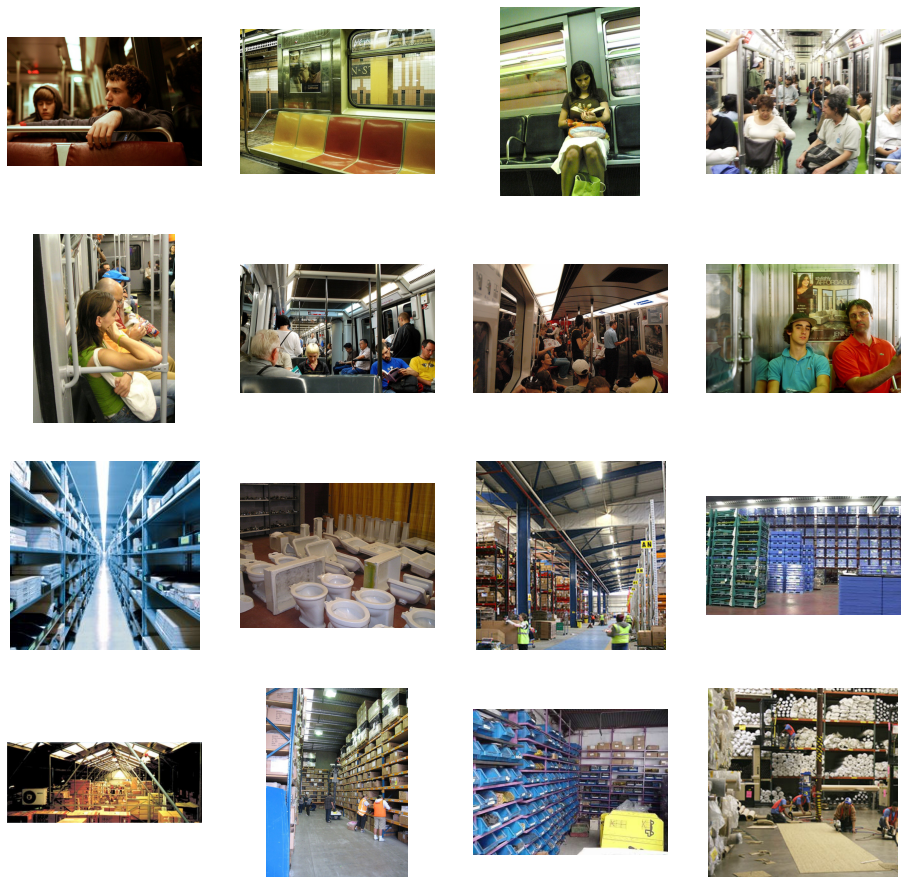

In [149]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_room_pix_0 = [os.path.join(TRAIN_DIR, fname) 
                for fname in train_dir_names_0[pic_index-8:pic_index]]
next_room_pix_1 = [os.path.join(TRAIN_DIR, fname) 
                for fname in train_dir_names_1[pic_index-8:pic_index]]

look_at_pictures(next_room_pix_0 + next_room_pix_1)

Os blocos seguintes sao para serem executados apos o treinamento do modelo com *data augmentation*.  
Permite visualizar as transformaçoes foram realizadas.

In [132]:
AUGMENTED_TRAIN_DIR = "/content/drive/MyDrive/MBA_data/deep_learning/images"
aug_train_dir_names = os.listdir(AUGMENTED_TRAIN_DIR)

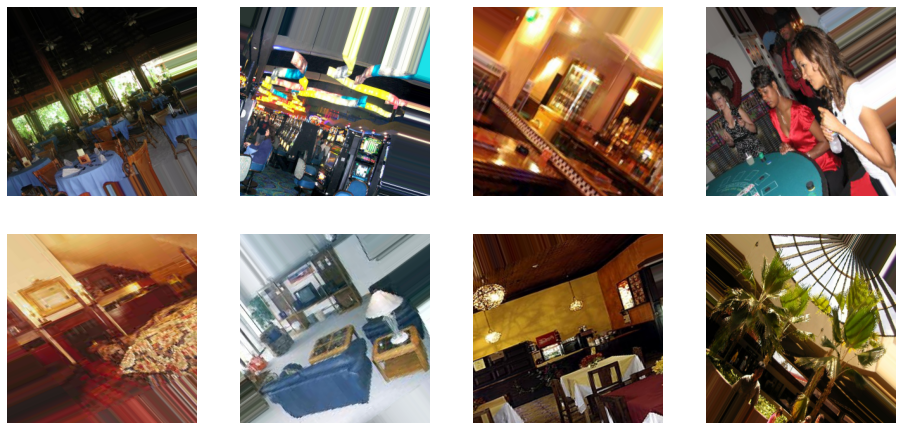

In [133]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_room_pix = [os.path.join(AUGMENTED_TRAIN_DIR, fname) 
                for fname in aug_train_dir_names[pic_index-8:pic_index]]
look_at_pictures(next_room_pix)

# Preparando os *generators*

In [10]:
print(len(train_dir_names))
print(len(test_dir_names))

3915
1929


Existem **3915** imagens no diretório de treinamento, portanto, estamos carregando-as em **135** de cada vez. Precisamos fazer **29** *batches* para carregar todas elas.

In [107]:
# BATCHSIZE = 29
# Try with 45 to have a gradient calculated with more representative data
BATCHSIZE = 45
# IMAGE_SIZE = 32
IMAGE_SIZE = 300

# train_datagen = ImageDataGenerator(rescale=1./255.,
#                             validation_split=0.25)

# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255.,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest',
                            validation_split=0.25)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [151]:
# Test for visualizing the generated images
# Uncomment the following block of code and save_to_dir in flow_from_dataframe function
# so you can generate a sample of the augmented images in the destination folder

# l = []
# for i in range(10):
#     for index, row in train_df[train_df.Class == str(i)].iloc[:5].iterrows():
#         l.append(row)
# train_df = pd.DataFrame(l)

In [160]:
train_generator=train_datagen.flow_from_dataframe(
                                                dataframe=train_df,
                                                directory=TRAIN_DIR,
                                                x_col="img_file",
                                                y_col="Class",
                                                subset="training",
                                                batch_size=BATCHSIZE,
                                                seed=42,
                                                shuffle=True,
                                                class_mode="categorical",
                                                # save_to_dir="/content/drive/MyDrive/MBA_data/deep_learning/images", # This allows you to optionally specify a 
                                                # directory to which to save the augmented pictures being generated 
                                                #(useful for visualizing what you are doing).
                                                target_size=(IMAGE_SIZE,IMAGE_SIZE))

valid_generator=train_datagen.flow_from_dataframe(
                                                dataframe=train_df,
                                                directory=TRAIN_DIR,
                                                x_col="img_file",
                                                y_col="Class",
                                                subset="validation",
                                                batch_size=BATCHSIZE,
                                                seed=42,
                                                shuffle=True,
                                                class_mode="categorical",
                                                target_size=(IMAGE_SIZE,IMAGE_SIZE))

test_datagen=ImageDataGenerator(rescale=1./255.)

# Sem shuffle para deixar a mesma ordenaçao de submissao
test_generator=test_datagen.flow_from_dataframe(
                                                dataframe=test_df,
                                                directory=TEST_DIR,
                                                x_col="img_file",
                                                y_col=None,
                                                batch_size=BATCHSIZE,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(IMAGE_SIZE,IMAGE_SIZE))

Found 2937 validated image filenames belonging to 10 classes.
Found 978 validated image filenames belonging to 10 classes.
Found 1929 validated image filenames.


# Criando a estrutura da Rede Neural

In [161]:
model = models.Sequential()
# This is the first convolution
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
# The second convolution
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# The third convolution
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Flatten the results to feed into a DNN
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
# 64 neuron hidden layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
flatten_7 (Flatten)          (None, 322624)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 322624)           

# Treinar e Avaliar a Rede Neuronal

In [162]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stop on validation loss
# monitor_val_loss = EarlyStopping(monitor = 'val_loss', patience = 10)
monitor_val_loss = EarlyStopping(monitor = 'val_accuracy', patience = 10)

# Save the best model as best_model.hdf5
# modelCheckpoint = ModelCheckpoint('best_model.hdf5', save_best_only = True)
modelCheckpoint = ModelCheckpoint('best_model.hdf5', monitor="val_accuracy", save_best_only = True)

In [163]:
STEP_SIZE_TRAIN=train_generator.n//min(train_generator.batch_size, train_generator.n)
STEP_SIZE_VALID=valid_generator.n//min(valid_generator.batch_size, train_generator.n)
STEP_SIZE_TEST=test_generator.n//min(test_generator.batch_size, train_generator.n)

In [164]:
# TODO: testar com diferente valores de optimizer, loss
# metrica de avaliaçao: logloss
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [168]:
# Carrega as imagens em blocos na memoria
history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=5, # TODO: Change this to a larger number to train for longer
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
    callbacks = [monitor_val_loss, modelCheckpoint],
    use_multiprocessing=True,
    workers=8,
    max_queue_size=100  # Change this number based on memory restrictions
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
65/65 [==============================] - 525s 8s/step - loss: 1.7964 - accuracy: 0.3237 - val_loss: 1.8697 - val_accuracy: 0.3164
Epoch 2/5
65/65 [==============================] - 545s 8s/step - loss: 1.8223 - accuracy: 0.3264 - val_loss: 1.8670 - val_accuracy: 0.3196
Epoch 3/5
65/65 [==============================] - 524s 7s/step - loss: 1.8143 - accuracy: 0.3167 - val_loss: 1.8000 - val_accuracy: 0.3397
Epoch 4/5
65/65 [==============================] - 521s 7s/step - loss: 1.7682 - accuracy: 0.3406 - val_loss: 1.7844 - val_accuracy: 0.3217
Epoch 5/5
65/65 [==============================] - 544s 8s/step - loss: 1.7566 - accuracy: 0.3434 - val_loss: 1.7977 - val_accuracy: 0.3111


In [166]:
model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_TEST)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[1.8673734664916992, 0.2995910048484802]

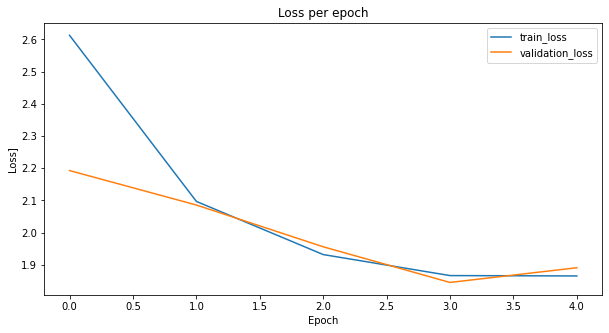

In [167]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss]')
plt.legend()

## Visualizar as representaçoes intermediarias

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


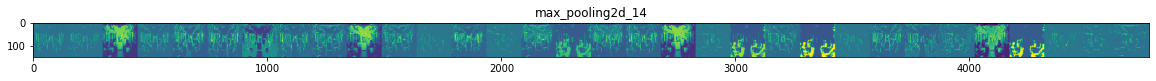

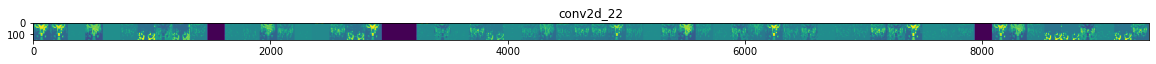

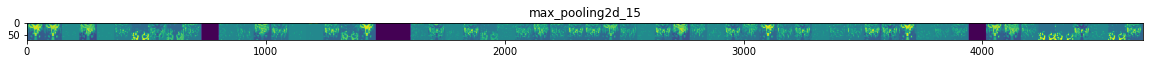

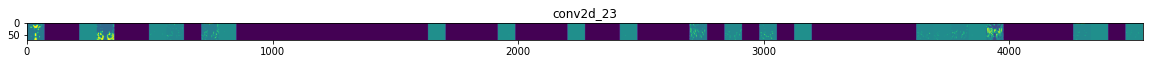

In [169]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image from the training set.
train_img_files = [os.path.join(TRAIN_DIR, f) for f in train_dir_names_0]
img_path = random.choice(train_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Hyperparameters tuning

In [ ]:
# Define the parameters to try out
params = {'dropout_rate': [0.25, 0.5, 0.75], 'batch_size': [29, 45, 87, 135], 'learning_rate': [0.1, 0.01, 0.001]}

In [ ]:
# Creates a model given an activation and learning rate
def create_model(learning_rate, dropout_rate):
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr = learning_rate)

    # Create your multiclass classification model  
    model = models.Sequential()
    # This is the first convolution
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    # The second convolution
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # The third convolution
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # Flatten the results to feed into a DNN
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    # 64 neuron hidden layer
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    # Compile your model with your optimizer, loss, and metrics
    model.compile(optimizer = opt, loss = 'cross-entropy', metrics = ['accuracy'])
    return model

In [ ]:
# Import KerasClassifier from keras scikit learn wrappers
from keras.wrappers.scikit_learn import KerasClassifier

# Create a KerasClassifier
model = KerasClassifier(build_fn=create_model)

In [ ]:
# Create a randomize search cv object passing in the parameters to try
random_search = RandomizedSearchCV(model, param_distributions=params, cv=3, random_state=42)

In [ ]:
history = random_search.fit_generator(
    generator=train_generator, 
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=30, # TODO: Change this to a larger number to train for longer
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
    callbacks = [monitor_val_loss, modelCheckpoint],
    use_multiprocessing=True,
    workers=8,
    max_queue_size=100  # Change this number based on memory restrictions
)

# Transfer Learning

**GoogLeNet** or **Inception-v1**  

**Inception-v3** is a convolutional neural network architecture from the Inception family that makes several improvements including 
- using Label Smoothing, Factorized 7 x 7 convolutions, 
- and the use of an auxiliary classifer to propagate label information lower down the network (along with the use of batch normalization for layers in the sidehead).

**Inception Module**:

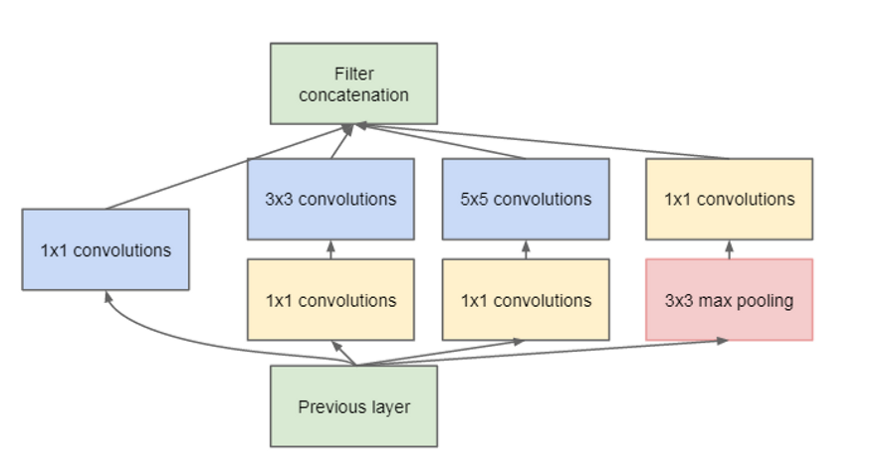

**ValueError**: Input size must be at least 75x75; got `input_shape=(32, 32, 3)`

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights='imagenet')

# pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
# pre_trained_model.summary()

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final softmax layer for classification
x = layers.Dense(10, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# Carrega as imagens em blocos na memoria
history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=100, # TODO: Change this to a larger number to train for longer
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
    callbacks = [monitor_val_loss, modelCheckpoint],
    use_multiprocessing=True,
    workers=8,
    max_queue_size=100  # Change this number based on memory restrictions
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
91/91 [==============================] - 60s 579ms/step - loss: 2.2883 - accuracy: 0.4348 - val_loss: 1.2334 - val_accuracy: 0.5406
Epoch 2/100
91/91 [==============================] - 44s 457ms/step - loss: 1.0929 - accuracy: 0.5900 - val_loss: 1.0112 - val_accuracy: 0.6292
Epoch 3/100
91/91 [==============================] - 44s 443ms/step - loss: 0.9924 - accuracy: 0.6478 - val_loss: 0.9557 - val_accuracy: 0.6281
Epoch 4/100
91/91 [==============================] - 44s 454ms/step - loss: 0.9059 - accuracy: 0.6640 - val_loss: 0.9992 - val_accuracy: 0.6573
Epoch 5/100
91/91 [==============================] - 44s 452ms/step - loss: 0.8569 - accuracy: 0.6878 - val_loss: 0.9725 - val_accuracy: 0.6698
Epoch 6/100
91/91 [==============================] - 53s 549ms/step - loss: 0.8396 - accuracy: 0.7015 - val_loss: 0.9810 - val_accuracy: 0.6406
Epoch 7/100
91/91 [==============================] - 44s 456ms/step - loss: 0.7779 - accuracy: 0.7219 - val_loss: 0.8548 - val_accuracy:

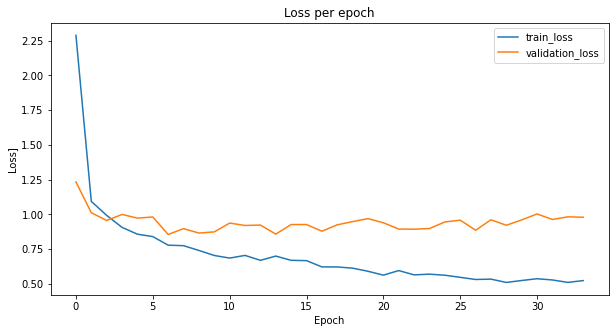

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss]')
plt.legend()

In [ ]:
model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_TEST)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.9325763583183289, 0.6912065148353577]

O melhor resultado foi obtido com o **Transfer Learning** a partir da rede neuronal da **Google Net**.

# Loading saved model

In [ ]:
from tensorflow import keras
best_model = keras.models.load_model('/content/best_model.hdf5')

In [ ]:
# Re-evaluate the model
loss, acc = best_model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_TEST)
print("Restored model, val accuracy: {:5.2f}% and val loss: {:5.2f}".format(100 * acc, loss))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Restored model, val accuracy: 70.86% and val loss:  0.89


# Executar o modelo

Faça o upload de uma imagem do seu sistema local e ve se o modelo acertou a categoria.

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = best_model.predict(images, batch_size=10)
  
  print("Picture category is: ", classes[0]) 

# Submission

In [ ]:
test_generator.reset()
pred=best_model.predict_generator(test_generator,
                                steps=STEP_SIZE_TEST+1,
                                verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


61/61 [==============================] - 17s 261ms/step


In [ ]:
sample_sub = pd.read_csv(SOURCE_DIR + '/submission.csv')
sample_sub

,Id,class0,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,10159,0.178924,0.168852,0.014027,0.042501,0.099851,0.103802,0.062335,0.102328,0.164840,0.062541
1,14903,0.070077,0.136654,0.035496,0.133790,0.107484,0.176830,0.101315,0.113647,0.058935,0.065773
2,44,0.158091,0.134758,0.083090,0.024502,0.158469,0.067026,0.113722,0.101362,0.063018,0.095962
3,3711,0.128932,0.002685,0.080441,0.069779,0.038477,0.023519,0.143680,0.088368,0.270420,0.153699
4,1730,0.155393,0.136195,0.110990,0.054077,0.042033,0.143044,0.040616,0.157772,0.071429,0.088451
...,...,...,...,...,...,...,...,...,...,...,...
1924,9732,0.128828,0.095081,0.050436,0.117802,0.194012,0.017082,0.080859,0.113110,0.148856,0.053935
1925,8306,0.018320,0.056601,0.072309,0.154384,0.217393,0.056973,0.072994,0.166256,0.080251,0.104520
1926,13910,0.069137,0.159557,0.087736,0.076663,0.019127,0.114679,0.229777,0.026071,0.134983,0.082269
1927,8687,0.178532,0.199236,0.006246,0.001565,0.065574,0.113542,0.196161,0.160892,0.017760,0.060493


In [ ]:
submission = pd.DataFrame(pred)
submission.columns = sample_sub.columns[1:]
submission['Id'] = sample_sub['Id']
submission = submission[sample_sub.columns]
submission

,Id,class0,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,10159,7.035695e-05,2.116907e-02,1.573848e-01,5.382958e-04,3.012872e-05,4.878484e-02,3.745244e-04,6.493161e-03,7.345804e-01,3.057435e-02
1,14903,2.553776e-07,9.395389e-01,1.383017e-07,7.037397e-07,2.040945e-03,2.788050e-09,5.841838e-02,2.843155e-08,6.554735e-07,5.637829e-10
2,44,9.905931e-02,3.161915e-03,4.493430e-03,9.354876e-02,2.808368e-04,3.791915e-02,7.612429e-01,9.909176e-06,2.328099e-04,5.108136e-05
3,3711,2.527409e-07,2.286921e-08,4.124317e-02,8.048499e-01,1.597583e-10,1.538307e-01,7.593346e-05,1.054769e-12,6.366469e-10,2.830948e-12
4,1730,3.330559e-05,3.380754e-04,5.632932e-01,5.539411e-03,5.810875e-05,3.824959e-01,2.901531e-04,3.049908e-03,2.835625e-02,1.654570e-02
...,...,...,...,...,...,...,...,...,...,...,...
1924,9732,7.371327e-05,1.247836e-03,7.540398e-02,5.346931e-04,4.906519e-05,5.567146e-02,7.153114e-04,4.666349e-02,8.119069e-01,7.733524e-03
1925,8306,4.446475e-09,1.063434e-04,4.317157e-02,1.421383e-07,1.495523e-09,4.734091e-02,2.364446e-07,2.016173e-05,2.419579e-02,8.851649e-01
1926,13910,7.139621e-05,2.980855e-09,2.234878e-06,3.621112e-08,9.999259e-01,8.115569e-08,3.372711e-07,3.251259e-09,8.869197e-09,2.363762e-08
1927,8687,4.978657e-05,2.000462e-03,8.219644e-02,1.565157e-03,5.597278e-04,7.949342e-02,2.907400e-04,6.757913e-02,7.822543e-03,7.584425e-01


In [ ]:
submission.to_csv('sub01.csv', index=False)

# Clean Up

In [ ]:
# Run the following cell to terminate the kernel and free memory resources
import os, signal
os.kill(os.getpid(), signal.SIGKILL)